# Importations

In [1]:
import pandas as pd
from math import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import dateutil.parser
import re
import contextualbandits
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from scipy import stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
import statsmodels.api as sm
import statsmodels.tsa.stattools as tsa

pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)

%matplotlib inline
sns.set_palette("hls")

# Fonctions

#### PlayArm :

The variable arm represents the selected arm visitor_reward is a dataframe of rewards iter is the current iteration S is the matrix of results for each arm (tests and empirical mean) In the matrix S :

Retrieves the reward associated with the iter instant in the reward dataframe

- Updates the average reward of the chosen arm with the reward obtained

- Adds a test to the selected arm (arm)

- Returns the updated S matrix



Arguments :

- iter : Integer value

- arm : Integer value

- S : Array

- visitor_reward : Array



Value :

- S : Array

In [ ]:
def PlayArm(iter,arm,S,visitor_reward):
    #mean
    arm = int(arm)
    iter = int(iter)
    S[0,arm] = (S[0,arm]*S[1,arm] + visitor_reward[iter,arm]) / (S[1,arm]+1)
    #play
    S[1,arm] += 1
    return S

#### ControlDataMissing :

Control data for bandit. Check in a dataframe if there is some missing values Print a message if it's not respected. Else return TRUE.



Arguments :

- visitor_reward : Dataframe of integers or numeric values



Value :

- Logical value

In [ ]:
def ControlDataMissing(visitor_reward):
    t = pd.DataFrame.isnull(visitor_reward)
    c = sum(pd.DataFrame.sum(t))
    
    if c > 0 :
        raise ValueError('Missing data in arm results database')

#### DataControlK :

Control arm and data for bandit Check if a dataframe gets an equal number of colonms than K possible arms. Check if K geq 2. Print a message and stop if this two conditions are not respected. Else return TRUE.



Arguments :

- visitor_reward : Dataframe of integer or numeric values

- K : Integer value (optional)



Value :

- Logical value

In [ ]:
def DataControlK(visitor_reward, K = None):
    if K == None :
        K = np.shape(visitor_reward)[1]
    
    if K < 2 :
        raise ValueError('Arm must be superior or equal to 2')
    
    if np.shape(visitor_reward)[1] != K :
        raise ValueError('Each arm need a result')

#### BanditsRewardControl :

Control data for bandit algorithm. See also ControlDataMissing and DataControlK



Arguments :

- visitor_reward : Dataframe of integer or numeric values

- K : Integer value (optional)



Value :

- Logical value

In [2]:
def BanditRewardControl(visitor_reward, K=None):
    DataControlK(visitor_reward,K)
    ControlDataMissing(visitor_reward)

#### ProbaMaxForUCB :

Calculates, for each colonne of S (selected arm) an upper bound according to the Hoeffding inequality (dependent on the iter iteration). It is possible to adjust this bound via an alpha parameter (default alpha = 1). Returns a vector of calculated upper bounds



Arguments :

- S : array

- iter : Integer value

- alpha : Numeric value (optional)

- K : Integer value (optional)



Value :

- array

In [1]:
def ProbaMaxForUCB(S,iter,alpha,K):
    choice = np.zeros(K)
    for j in range(K):
        choice[j] = S[0,j] + alpha*sqrt(2*log(iter+1)/S[1,j])
    return choice

#### ConditionForUCB :

Calculates, for each colonne of S (selected arm) an upper bound according to the Hoeffding inequality (dependent on the iter iteration) via ProbaMaxForUCB function It is possible to adjust this bound via an alpha parameter (default alpha = 1). Returns the arm with the highest bound See also ProbaMaxForUCB



Arguments :

- S : array

- iter : Integer value

- alpha : Numeric value (optional)

- K : Integer value (optional)



Value :

- integer value

In [2]:
def ConditionForUCB(S,iter,alpha,K):
    return np.argmax(ProbaMaxForUCB(S,iter,alpha,K))

#### UCB :

Control data in visitor_reward with BanditRewardControl Stop if something is wrong. Generate a matrix to save the results (S).

At each iteration :

- Calculates the arm probabilities

- Choose the arm with the maximum upper bound (with alpha parameter)

- Receives a reward in visitor_reward for the arm and associated iteration

- Updates the results matrix S.

Returns the calculation time. Review the estimated, actual averages and number of choices for each arm. See also ConditionForUCB, ProbaMaxForUCB and PlayArm.



Arguments :

- visitor_reward : Dataframe of integer or numeric values

- K : Integer value (optional)

- alpha : Numeric value (optional)



Values :

List of element:

- S : numerical matrix of results ,

- choice : choices of UCB,

- proba : probability of the chosen arms,

- time : time of cumputation,

- theta_hat : mean estimated of each arm

- theta : real mean of each arm

In [3]:
def UCB(visitor_reward0, K = None, alpha = None):
    
    if K == None :
        K = visitor_reward0.shape[1]
    if alpha == None :
        alpha = 1
    
    BanditRewardControl(visitor_reward0, K)
    
    # data formating
    visitor_reward = np.array(visitor_reward0)
    n = np.shape(visitor_reward)[0]

    # keep list of choices
    choice = np.zeros(n)
    proba = np.zeros(n)
    S = np.zeros((2,K))
    tic = time.time()
    
    if K >= n :
        print("Warning : More arms than visitors")
        
        for j in range(n):
            proba[j] = max(ProbaMaxForUCB(S,j,alpha,K))
            S = PlayArm(j,j,S,visitor_reward)
        choice = np.arange(0,n+1,1)

        if K > n :
            S[:,j:K] = 0
        return [S,choice]
    else :
        
        # initialisation
        
        for j in range(K):
            proba[j] = max(ProbaMaxForUCB(S,j,alpha,K))
            S = PlayArm(j,j,S,visitor_reward)
            choice[j] = j
            
        for i in range(K,n):
            choice[i] = ConditionForUCB(S,i,alpha,K)
            proba[i] = max(ProbaMaxForUCB(S,i,alpha,K))
            S = PlayArm(i,choice[i],S,visitor_reward)
            
        toc = time.time()
        
        # coef estimate
        theta_hat = S[0,:]
        
        # real coef
        theta = pd.DataFrame.mean(visitor_reward0)
        
        return [S,choice,proba,toc-tic,theta_hat,theta]

#### Regret :

See "cumulative_regret.ipynb"

In [4]:
def SimpleRegret(choice,visitor_reward):
    visitor_reward
    n = visitor_reward.shape[0]
    regret = np.zeros(n)
    for i in range(n):
        regret[i] = RegretValue(choice[i],np.array(visitor_reward)[i,:])
    return regret

def RegretValue(arm, vec_visitor_reward):
    return max(vec_visitor_reward) - vec_visitor_reward[int(arm)]

def cumulativeRegret(choice,visitor_reward):
    regret = SimpleRegret(choice,visitor_reward)
    return np.cumsum(regret)

# Tests sur données générées :

Génération d'un problème de bandits avec 5 bras différents : V1,V2,V3,V4,V5; puis test de l'algo UCB sur celui-ci (avec tracé du regret).

In [5]:
V1 = np.random.binomial(1,0.6,5000)
V2 = np.random.binomial(1,0.7,5000)
V3 = np.random.binomial(1,0.5,5000)
V4 = np.random.binomial(1,0.3,5000)
V5 = np.random.binomial(1,0.9,5000)

a = np.transpose(np.array([V1,V2,V3,V4,V5]))

rewards0 = pd.DataFrame(a, columns = ['Bandit 1', 'Bandit 2', 'Bandit 3', 'Bandit 4', 'Bandit 5'])

In [6]:
rewards0.head()

Bandit 1  Bandit 2  Bandit 3  Bandit 4  Bandit 5
0         1         1         1         1         1
1         1         1         0         0         1
2         1         1         0         0         1
3         1         0         0         1         1
4         1         1         1         0         1

In [7]:
ucb_alloc0 = UCB(rewards0)

/tmp/ipykernel_28115/3518825791.py:4: RuntimeWarning: invalid value encountered in double_scalars
  choice[j] = S[0,j] + alpha*sqrt(2*log(iter+1)/S[1,j])
/tmp/ipykernel_28115/3518825791.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  choice[j] = S[0,j] + alpha*sqrt(2*log(iter+1)/S[1,j])


Tracé du regret cumulé au cours des itérations :

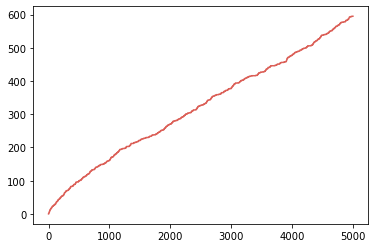

In [8]:
regret0 = cumulativeRegret(ucb_alloc0[1],rewards0)
plt.plot(regret0)

Affichage des choix effectués par l'algo UCB :

In [9]:
print("Choices")
print(ucb_alloc0[1])

Choices
[0. 1. 2. ... 4. 4. 4.]


Récompense moyenne approximée pour chaque bras :

In [10]:
print("Theta hat")
print(ucb_alloc0[4])

Theta hat
[0.59349593 0.71320755 0.45454545 0.27777778 0.90620843]


Récompense moyenne théorique pour chaque bras :

In [11]:
print("Theta")
print(ucb_alloc0[5])

Theta
Bandit 1    0.5922
Bandit 2    0.6942
Bandit 3    0.4980
Bandit 4    0.2978
Bandit 5    0.9070
dtype: float64
